## Generalized Principal Component Analysis of US Mortality Data

This notebook uses generalized Principal Component Analysis (GPCA)
to aid in understanding the patterns of variation in US mortality
data.  See the 'vital_stats_prep.py' file for more information about
the data.

GPCA is a technique for understanding data through dimension
reduction and correlation analysis.  Traditional PCA is widely used,
but may not perform well for data that have strong mean/variance
relationships.  Generalized Linear Models (GLMs) were developed to
handle this issue in a regression setting.  GPCA handles this issue
in a setting analogous to traditional PCA.

Another issue we wish to consider here is that we anticipate
variables indexed by a continuous value (e.g. time and age) to vary
smoothly with respect to their index.  Functional PCA was developed
to address this through regularization.  The GPCA method utilized
here is able to use the same functional approach.

These are the modules that we will be using here:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from gpca import GPCA

This is the path to the data file on your system.  You will need to
change this to match the path used in the `vital_stats_prep.py`
script.

In [2]:
pa = "/nfs/kshedden/cdc_mortality/final/pop_mort.csv"
df = pd.read_csv(pa)

## Factor structure of the age groups

PCA operates on a rectangular data matrix.  Depending on what we
want to focus on, we can choose one of several ways to create this
matrix.  Here, we will pivot the age groups to the columns to create
a rectangular matrix.

In [3]:
ix = ["Year", "Month", "Sex", "Age_group"]
dx = df.set_index(ix)
deaths = dx.loc[:, "Deaths"].unstack("Age_group")
deaths = deaths.fillna(1)

We may wish to adjust for certain important explanatory variables,
so that the PCA focuses on the variation around these variables.  A
basic variable to adjust for is the population size.  By adjusting
for population size, we are looking at mortality with respect to
population size ("death rates").

In [4]:
pop = dx.loc[:, "Population"].unstack("Age_group")
lpop = np.log(pop)

Below we fit the generalized PCA, using a Poisson family and two
factors (as with traditional PCA, we can extract any number of
factors up to the dimension of the data).  Since there are very
strong sex-differences in the mortality patterns, we will fit models
for females and for males separately.

In [5]:
rs, rq, da = [], [], []
for sex in "Female", "Male":
    dz = deaths.xs(sex, level="Sex")
    da.append(dz)
    offset = lpop.xs(sex, level="Sex")

    # Fit without penalty
    pca = GPCA(dz, 2, offset=offset, family=sm.families.Poisson())
    r = pca.fit(maxiter=500)
    rq.append(r)

    # Fit with penalty
    pca = GPCA(dz, 2, offset=offset, penmat=(0, 1), family=sm.families.Poisson())
    r = pca.fit(maxiter=500)
    rs.append(r)

/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning: divide by zero encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning: invalid value encountered in subtract
  return var_weights / scale * (endog * np.log(mu) - mu -


/afs/umich.edu/user/k/s/kshedden/Projects/Workshops/mortality/python/gpca.py:352: UserWarning: GPCA did not converge
  warnings.warn("GPCA did not converge")


The warning about convergence may be ignored as the norm of the
gradient is rather small.  Increase the number of iterations in the
fit calls above to get full convergence.

In [6]:
for r in rs:
    print(r.score_norm)

1.0162973557838706
0.12281429672363549


A generalized PCA identifies "intercepts", analogous to means, such
that variables with lesser intercepts tend to have smaller values
than variables with greater intercepts. The utility function below
plots the intercepts.

In [7]:
def plot_intercepts(r):
    ages = deaths.columns
    plt.clf()
    plt.axes([0.1, 0.1, 0.7, 0.8])
    plt.grid(True)
    plt.plot(ages, r[0].intercept, label="Female")
    plt.plot(ages, r[1].intercept, label="Male")
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)
    plt.xlabel("Ages")
    plt.ylabel("Intercepts")
    xl = plt.gca().xaxis.get_ticklabels()
    for x in xl:
        x.set_rotation(90)

The plot below shows the intercepts for women and for men. This
reflects the expected mortality profile in which there is elevated
mortality for children under 5, and progressively increasing
mortality from ages 5 and up.  Men have higher mortality risk than
women at every age, and especially between ages 15 to 30 where men
have substantially elevated mortality due to injuries and violence,
among other factors.

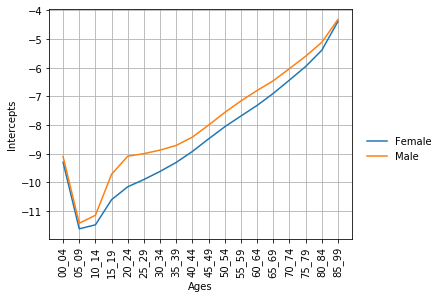

In [8]:
plot_intercepts(rs)

Next we have a utility function that plots the loadings of the
two-factor fit.

In [9]:
def plot_factors(r, title):
    ages = deaths.columns
    plt.clf()
    plt.axes([0.1, 0.1, 0.73, 0.8])
    plt.grid(True)
    for j in range(r.factors.shape[1]):
        plt.plot(ages, r.factors[:, j], label=str(j+1))
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)
    plt.xlabel("Ages")
    plt.ylabel("Factor loadings")
    plt.title(title)
    xl = plt.gca().xaxis.get_ticklabels()
    for x in xl:
        x.set_rotation(90)

The following two plots show the factor loadings, as functions of
age, for women and for men.  These factors are estimated using
penalized estimation so that the estimated loading patterns are
smooth.  We used a smoothing penalty parameter of 1 for the factor
loadings, and the intercepts are unpenalized.  We will not spend
time here optimizing these values.

The dominant factors for women and for men have almost entirely
positive loadings, and the loadings are especially high for adults.
This means that the dominant factor captures a pattern of variation
in which demographic/temporal cells that score positively on this
factor have greater mortality for adults, and demographic/temporal
cells that score negatively on this factor have lesser mortality for
adults.

The second factor captures a pattern in which mortality is lower
between ages 20 and 40, and higher for people over 50 and under 5.
This can be viewed as the "age gradient" for mortality, capturing
the expected relationship in which older people are at greater risk
for dying than younger people.  Demographic cells that score
positively on this factor have more mortality for people over 50 and
under 5, and less mortality for people between 50 and 5.
Demographic cells that score negatively on this factor have
relatively less mortality for people over 50 and under 5, and more
mortality for people between 5 and 50.

Negative scores on factor 2 may correspond to a flattening of the
age gradient, associated with relatively higher rates of death in
middle age.  This could be due to recent trends in accidents, drug
overdoses, and suicides.

It is important to note that whenever we interpret a factor as
implying "more" or "less" mortality, we always mean this to be
relative to the mortality implied by the intercept for that age
band, which is approximately equal to the mean age-specific
mortality.

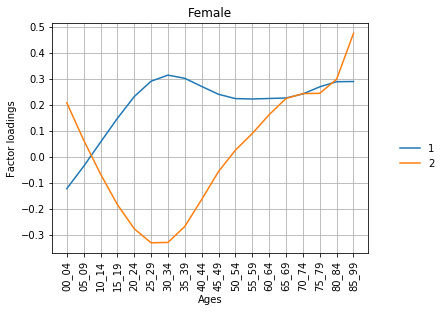

In [10]:
plot_factors(rs[0], "Female")

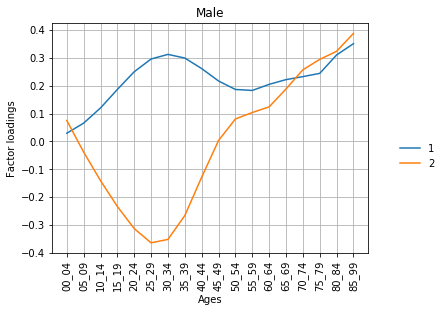

In [11]:
plot_factors(rs[1], "Male")

For comparison, the following two plots show the unpenalized factor
loadings.  Notably, the penalized factor loadings are very similar
for women and men, but the unpenalized loadings are quite different.
It seems possible that the unpenalized loadings may be artificially
different due to low power.

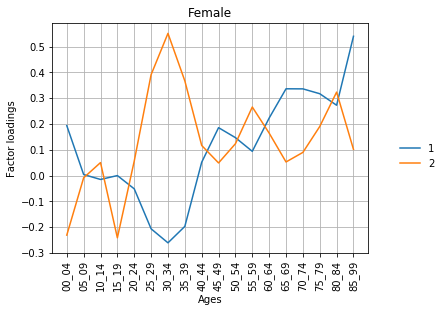

In [12]:
plot_factors(rq[0], "Female")

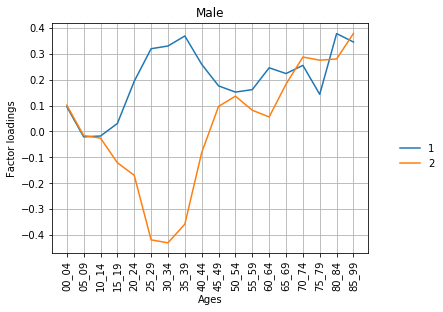

In [13]:
plot_factors(rq[1], "Male")

One of the best ways to understand the factors is to look at the
scores, which are in one-to-one correspondence with the rows of the
data matrix.  The scores in our case are records of deaths in sex x
month x year cells.  To make this plot, we first prepare a dataframe
containing the scores together with some other relevant variables.

In [14]:
def make_scores(r, dx):

    scores = pca.scores(r.params)
    month = dx.index.get_level_values("Month")
    year = dx.index.get_level_values("Year")

    scores = pd.DataFrame(scores)
    scores.columns = ["factor%d" % (j+1) for j in range(scores.shape[1])]
    scores["month"] = month
    scores["year"] = year

    return scores

scores = [make_scores(rs[j], da[j]) for j in (0, 1)]

The following utility function plots the scores from the dominant
two factors as a scatterplot, coloring the points by month.

In [15]:
def plot_scores(scores, title):
    plt.clf()
    plt.axes([0.1, 0.1, 0.75, 0.8])
    plt.grid(True)
    cm = plt.get_cmap("cool")
    col = [None] + [cm(x) for x in np.linspace(0, 1, 13)]
    for m in range(1, 13):
        ii = np.flatnonzero(scores.month == m)
        plt.plot(scores.factor1[ii], scores.factor2[ii], 'o',
                 color=col[m], label=str(m))
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right", handletextpad=0.001)
    leg.draw_frame(False)
    plt.title(title)
    plt.xlabel("Scores for component 1")
    plt.ylabel("Scores for component 2")

The following two plots show the scores for the two factors, for
women and for men.  In a traditional Gaussian PCA, the scores are
uncorrelated and centered.  Here, since this is a Poisson PCA, we
don't have these properties exactly, but the scores are evidently
approximately uncorrelated.

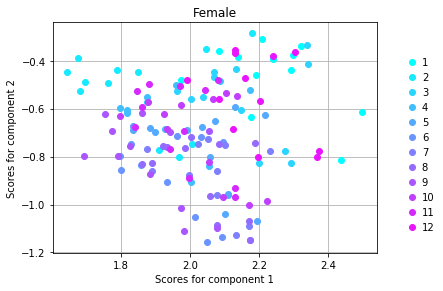

In [16]:
plot_scores(scores[0], "Female")

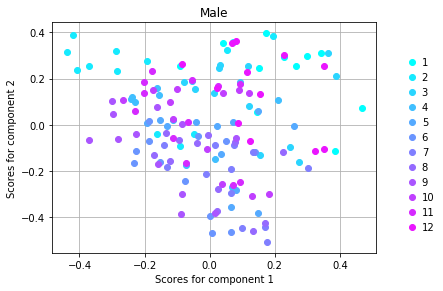

In [17]:
plot_scores(scores[1], "Male")

Next we will look at how the factor scores vary by month.  We first
create a function that will generate a scatterplot of the factor
scores against the month, for any factor in the model.

In [18]:
def plot_month(factor, scores, title):
    plt.clf()
    plt.axes([0.1, 0.1, 0.73, 0.8])
    plt.grid(True)
    cm = plt.get_cmap("cool")
    col = [cm(x) for x in np.linspace(0, 1, 12)]
    for year in range(2007, 2019):
        scores1 = scores.loc[scores.year == year, :]
        plt.plot(scores1.month, scores1.loc[:, factor], 'o',
                 color=col[year-2007], label=str(year))
    plt.xlabel("Month")
    plt.ylabel("Score")
    plt.title(factor + " " + title)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right", handletextpad=0.01)
    leg.draw_frame(False)

The following two figures show scatterplots of the factor 1 scores
against month.  Recall that higher scores for factor 1 correspond to
greater mortality in all age bands (though not all to the same
extent).  The scores for this factor tend to be higher in December,
January, and March.  This largely reflects increased mortality in
the winter due to respiratory diseases such as influenza, and also
may be influenced by excess mortality in January thought to be
related to the holidays.

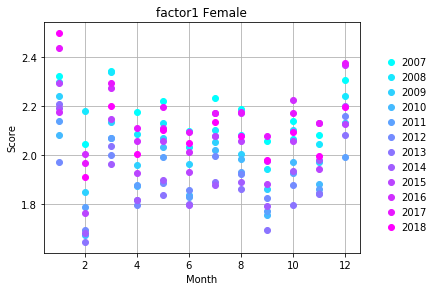

In [19]:
plot_month("factor1", scores[0], "Female")

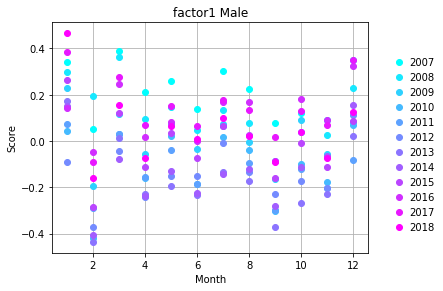

In [20]:
plot_month("factor1", scores[1], "Male")

Next we create a scatterplot of factor 2 scores against month.  It
shows clearly that summer months tend to have negative scores for
factor 2, and winter months tend to have positive scores for factor
2.  This indicates that winter months have greater mortality among
the elderly and lesser mortality among young adults (compared to the
intercepts), while summer months have somewhat less age-specific
variation in the mortality patterns.

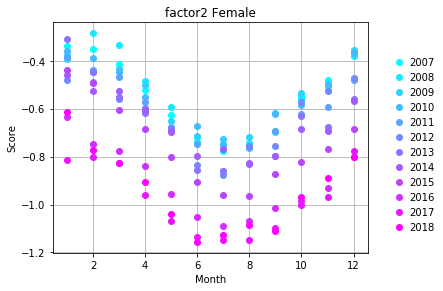

In [21]:
plot_month("factor2", scores[0], "Female")

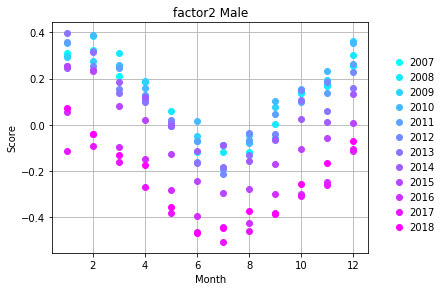

In [22]:
plot_month("factor2", scores[1], "Male")

In [23]:
def plot_year(factor, scores, title):
    plt.clf()
    plt.axes([0.1, 0.1, 0.73, 0.8])
    plt.grid(True)
    cm = plt.get_cmap("cool")
    col = [cm(x) for x in np.linspace(0, 1, 13)]
    for m in range(1, 13):
        scores1 = scores.loc[scores.month == m, :]
        plt.plot(scores1.year, scores1.loc[:, factor], 'o',
                 color=col[m-1], label=str(m))
    plt.xlabel("Year")
    plt.ylabel("Score")
    plt.title(factor + " " + title)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right", handletextpad=0.01)
    leg.draw_frame(False)

Next we look at how the factor scores vary by year.  The factor 1
scores are slightly higher at the beginning and end of the time
range covered by these data, with a minimum around 2012.  This may
reflect a steady decline in mortality that reversed for a few years
after 2012.

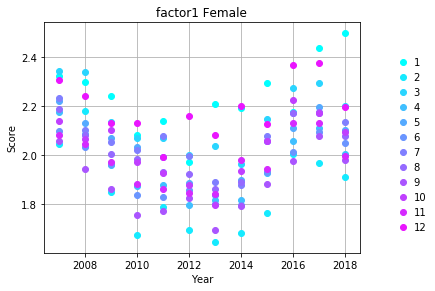

In [24]:
plot_year("factor1", scores[0], "Female")

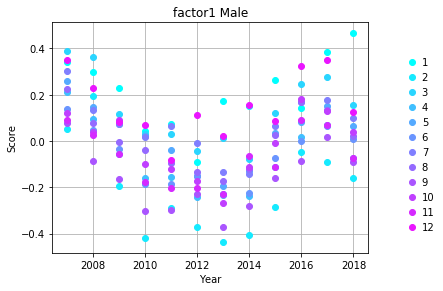

In [25]:
plot_year("factor1", scores[1], "Male")

The factor 2 scores decrease over the 12 years of data considered
here.  This seems to indicate a weakening of the tendency for
mortality to be concentrated among older people in the winter
months.

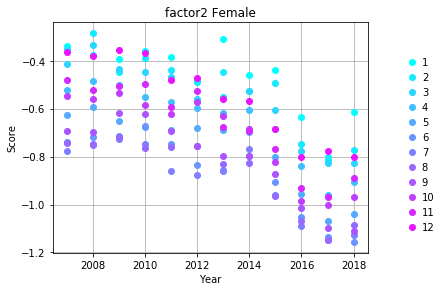

In [26]:
plot_year("factor2", scores[0], "Female")

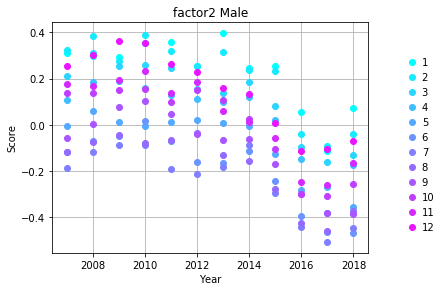

In [27]:
plot_year("factor2", scores[1], "Male")